# The Hammurabi simulator 

This tutorial shows how to use the [Hammurabi](https://imagine-code.readthedocs.io/en/latest/imagine.simulators.html#module-imagine.simulators.hammurabi) simulator class the interface to [hammurabiX](https://bitbucket.org/hammurabicode/hamx/src/master/) code.

Throughout the tutorial, we will use the term 'Hammurabi' to refer to 
the Simulator class, and 'hammurabiX' to refer to the hammurabiX software.

In [1]:
import matplotlib
%matplotlib inline

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import imagine as img

import imagine.observables as img_obs
import astropy.units as u
import cmasher as cmr
import copy

matplotlib.rcParams['figure.figsize'] = (10.0, 4.5)

## Initializing 

In the normal IMAGINE workflow, the simulator produces a set of mock 
observables (Simulators in IMAGINE jargon) which one wants to compare 
with a set of observational data (i.e. Measurements). Thus, the 
Hammurabi simulator class (as any IMAGINE simulator) has to be 
initialized with a Measurements object in order to know properties
of the output it will need to generate.

Therefore, we begin by creating fake, empty, datasets which will help 
instructing Hammurabi which observational data we are interested in.

In [2]:
from imagine.observables import Measurements

# Creates some empty fake datasets 
size = 12*32**2 
sync_dset = img_obs.SynchrotronHEALPixDataset(data=np.empty(size)*u.mK, 
                                              frequency=23*u.GHz, typ='I')
size = 12*16**2
fd_dset = img_obs.FaradayDepthHEALPixDataset(data=np.empty(size)*u.rad/u.m**2)
size = 12*8**2
dm_dset = img_obs.DispersionMeasureHEALPixDataset(data=np.empty(size)*u.pc/u.cm**3)

# Appends them to an Observables Dictionary
fakeMeasureDict = Measurements(sync_dset, fd_dset, dm_dset)

Now it is possible initializing the simulator. The Hammurabi simulator prints its setup after initialization, showing that we have defined three observables.

In [3]:
from imagine.simulators import Hammurabi
simer = Hammurabi(measurements=fakeMeasureDict)

observable {}
|-->  sync {'cue': '1', 'freq': '23', 'nside': '32'}
|-->  faraday {'cue': '1', 'nside': '16'}
|-->  dm {'cue': '1', 'nside': '8'}


## Running with dummy fields

### Using only non-stochastic fields

In order to run an IMAGINE simulator, we need to specify a list of 
Field objects it will map onto observables.

The original hammurabiX code is *not only* a Simulator in IMAGINE's sense, but comes also with a large set of built-in fields. Using 
dummy IMAGINE fields, it is  possible to instruct Hammurabi to run using one of hammurabiX's built-in fields instead of evaluating an
IMAGINE Field.

A range of such dummy Fields and the associated Field Factories can be found in the subpackage [imagine.fields.hamx](https://imagine-code.readthedocs.io/en/latest/imagine.fields.hamx.html). 

Using some of these, let us initialize three dummy fields: one instructing Hammurabi to use one of hammurabiX's regular fields (`BregLSA`), one setting CR electron distribution (`CREAna`), 
and one setting the thermal electron distribution (`YMW16`).

In [4]:
from imagine.fields.hamx import BregLSA, CREAna, TEregYMW16

## ensemble size
ensemble_size = 2

## Set up the BregLSA field with the parameters you want:
paramlist = {'b0': 6.0, 'psi0': 27.9, 'psi1': 1.3, 'chi0': 24.6}
breg_wmap = BregLSA(parameters=paramlist, ensemble_size=ensemble_size)

## Set up the analytic CR model CREAna 
paramlist_cre = {'alpha': 3.0, 'beta': 0.0, 'theta': 0.0,
                 'r0': 5.6, 'z0': 1.2,
                 'E0': 20.5,
                 'j0': 0.03}
cre_ana = CREAna(parameters=paramlist_cre, ensemble_size=ensemble_size)

##  The free electron model based on YMW16, ie. TEregYMW16 
fereg_ymw16 = TEregYMW16(parameters={}, ensemble_size=ensemble_size)

Now we can run the Hammurabi to generate one set of observables

In [5]:
maps = simer([breg_wmap, cre_ana, fereg_ymw16])

The `Hammurabi` class wraps around hammurabiX's own python wrapper `hampyx`.  The latter can be accessed through the attribue
`_ham`.

It is generally convenient not using `hampyx` directly, considering future updates in hammurabiX. Nevertheless, there situations where 
this is still convenient, particularly while troubleshooting.

The direct access to `hampyx` is exemplified below, where we check its initialization, after running the simulation object.

In [6]:
simer._ham.print_par(['magneticfield', 'regular'])
simer._ham.print_par(['magneticfield', 'regular', 'wmap'])
simer._ham.print_par(['cre'])
simer._ham.print_par(['cre', 'analytic'])
simer._ham.print_par(['thermalelectron', 'regular'])

regular {'cue': '1', 'type': 'lsa'}
|-->  lsa {}
|-->  jaffe {}
|-->  unif {}
cre {'cue': '1', 'type': 'analytic'}
|-->  analytic {}
|-->  unif {}
analytic {}
|-->  alpha {'value': '3.0'}
|-->  beta {'value': '0.0'}
|-->  theta {'value': '0.0'}
|-->  r0 {'value': '5.6'}
|-->  z0 {'value': '1.2'}
|-->  E0 {'value': '20.5'}
|-->  j0 {'value': '0.03'}
regular {'cue': '1', 'type': 'ymw16'}
|-->  ymw16 {}
|-->  unif {}


Any `Simulator` by convention returns a `Simulations` object, which collect all required maps.  We want to get them back as arrays we can visualize with healpy.  The `data` attribute does this, and note that what it gets back is a **list** of two of each type of observable, since we specified `ensemble_size=2` above.  But since we have not yet added a random component, they are both the same:  

In [7]:
maps[('sync', 23., 32, 'I')].global_data

array([[0.08884023, 0.08772291, 0.08634578, ..., 0.08866684, 0.08728929,
        0.08849186],
       [0.08884023, 0.08772291, 0.08634578, ..., 0.08866684, 0.08728929,
        0.08849186]])

Below we exemplify how to (manually) extract and plot the simulated maps produced by Hammurabi:

/home/lrodrigues/miniconda3/envs/imagine/lib/python3.7/site-packages/healpy/projaxes.py:209: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds


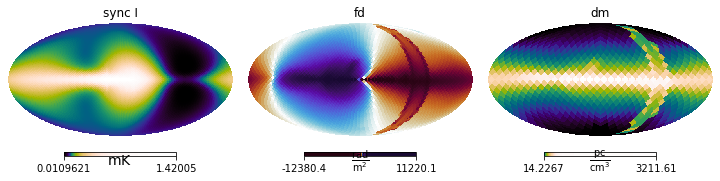

In [8]:
from imagine.tools.visualization import _choose_cmap

for i, key in enumerate(maps.keys()):
    simulated_data = maps[key].global_data[0]
    simulated_unit = maps[key].unit
    name = key[0]
    if key[3] is not None:
        name += ' '+key[3]
    hp.mollview(simulated_data, norm='hist', cmap=_choose_cmap(name),
                unit=simulated_unit._repr_latex_(), title=name, sub=(1,3,i+1))    

Alternatively, we can use a built-in method in the `Simulations` object to show its contents:

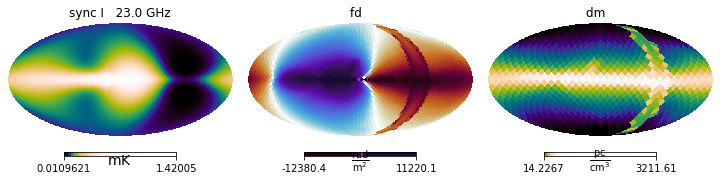

In [9]:
maps.show(max_realizations=1)

The keyword argument `max_realizations` limits the number of ensemble 
realisations that are displayed. 

### Using a stochastic magnetic field component

Now we add a random GMF component with the BrndES model.  This model starts with a random number generator to simulate a Gaussian random field on a cartesian grid and ensures that it is divergence free.  The grid is defined in hammurabiX XML parameter file.  

In [10]:
from imagine.fields.hamx import BrndES

paramlist_Brnd = {'rms': 6., 'k0': 0.5, 'a0': 1.7, 
                  'k1': 0.5, 'a1': 0.0,
                  'rho': 0.5, 'r0': 8., 'z0': 1.}

brnd_es = BrndES(parameters=paramlist_Brnd, ensemble_size=ensemble_size,
                 grid_nx=100, grid_ny=100, grid_nz=40)
# The keyword arguments grid_ni modify random field grid for limiting
# the notebook's memory consumption.

Now use the simulator to generate the maps from these field components and visualize:

In [11]:
maps = simer([breg_wmap, brnd_es, cre_ana, fereg_ymw16])

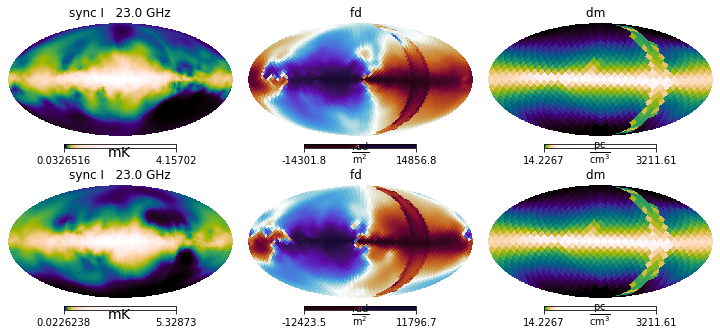

In [12]:
maps.show()

One can easily see the stochastic magnetic field in action by comparing
the different model realisations shown in different rows.

## Running with IMAGINE fields
### The basics

While hammurabiX's fields are extremely useful, we want the flexibility of quickly plugging *any* IMAGINE Field to hammurabiX. Fortunately, this is actually very easy. 
For the sake of simplificty, let us initialize a "fresh" simulator object.

In [13]:
simer = Hammurabi(measurements=fakeMeasureDict)

observable {}
|-->  sync {'cue': '1', 'freq': '23', 'nside': '32'}
|-->  faraday {'cue': '1', 'nside': '16'}
|-->  dm {'cue': '1', 'nside': '8'}


Now, let us initialize a few simple Fields and Grid 

In [14]:
from imagine.fields import ConstantMagneticField, ExponentialThermalElectrons, UniformGrid

# We initalize a common grid for all the tests, with 100^3 meshpoints
grid = UniformGrid([[-25,25]]*3*u.kpc,
                       resolution=[100]*3)

# Two magnetic fields: constant By and constant Bz across the box
By_only = ConstantMagneticField(grid,
                                parameters={'Bx': 0*u.microgauss,
                                            'By': 1*u.microgauss,
                                            'Bz': 0*u.microgauss})
Bz_only = ConstantMagneticField(grid,
                                parameters={'Bx': 0*u.microgauss,
                                            'By': 0*u.microgauss,
                                            'Bz': 1*u.microgauss})
# Constant electron density in the box
ne = ExponentialThermalElectrons(grid, parameters={'central_density' : 0.01*u.cm**-3,
                                                   'scale_radius' : 3*u.kpc,
                                                   'scale_height' : 100*u.pc})

We can run hammurabi by simply provinding the fields in the fields list

In [15]:
fields_list1 = [ne, Bz_only]
maps = simer(fields_list1)

We can now examine the results

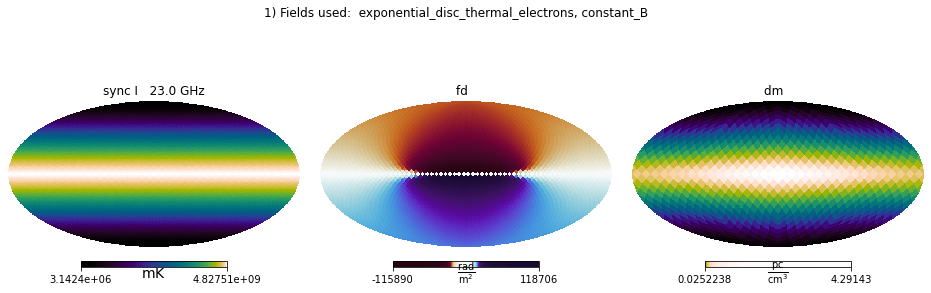

In [16]:
# Creates a list of names
field_names = [field.name for field in fields_list1]

fig = plt.figure(figsize=(13.0, 4.0))
maps.show()
plt.suptitle('1) Fields used:  ' + ', '.join(field_names));

Which is what one would expect for this very artificial setup.

As usual, we can combine different fields (fields of the same type are simply summed up. The following cell illustrates this.

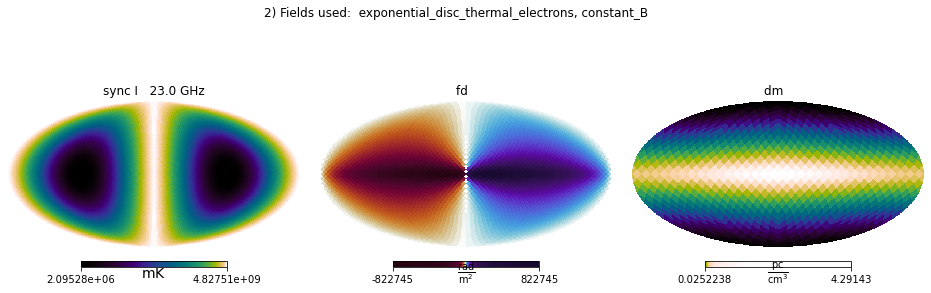

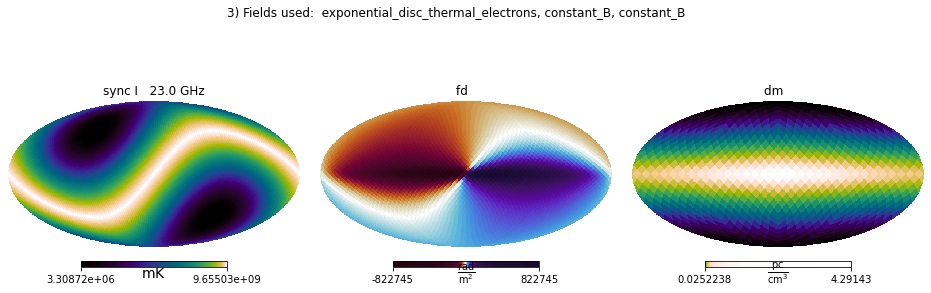

In [17]:
fields_list2 = [ne, By_only]
fields_list3 = [ne, By_only, Bz_only]

for i, fields_list in enumerate([fields_list2, fields_list3]):
    # Creates a list of names
    field_names = [field.name for field in fields_list]

    fig = plt.figure(figsize=(13.0, 4.0))
    maps = simer(fields_list)
    maps.show()
    plt.suptitle(str(i+2)+') Fields used:  ' + ', '.join(field_names));

### Mixing internal and IMAGINE fields

The dummy fields that enable hammurabiX's internal fields can be combined with normal IMAGINE Fields as long as they belong to different categories in hammurabiX's implementation. These are:
* regular magnetic field
* random magnetic field
* regular thermal electron density
* random thermal electron density
* cosmic ray electrons

Thus, if you provide IMAGINE Fields of a given field type, the corresponding hammurabiX built-in field is deactivated.

In the following example we illustrate using an IMAGINE field for the "regular magnetic field", and dummies for the "random magnetic field" and cosmic rays.



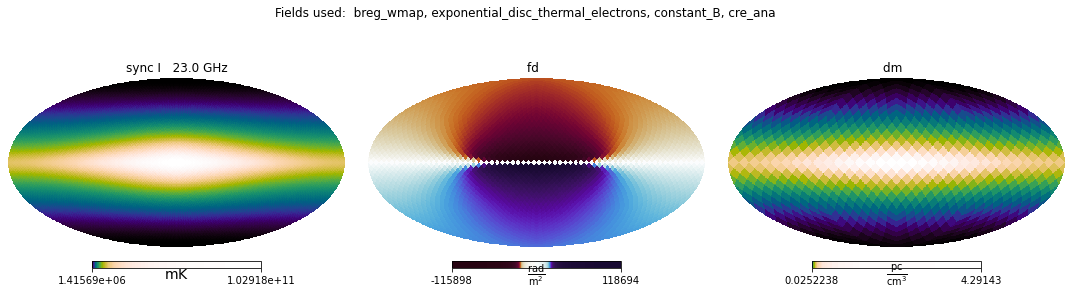

In [18]:
# Re-defines the fields, with the default ensemble size of 1
brnd_es = BrndES(parameters=paramlist_Brnd)
brnd_es.set_grid_size(nx=100, ny=100, nz=40)
cre_ana = CREAna(parameters=paramlist_cre)

fields_list = [brnd_es, ne, Bz_only, cre_ana]

field_names = [field.name for field in fields_list]
fig = plt.figure(figsize=(15.0, 4.0))
maps = simer(fields_list)
maps.show()
plt.suptitle('Fields used:  ' + ', '.join(field_names));

<!-- 
Note that hammurabi's random/regular do not coincide with IMAGINE's stochastic/deterministic -->